## 微信web 接口登录分析
网址: https://wx.qq.com/

### 1. 网址分析
打开网址我们可以看到如图所示的页面:  
![web页面](./images/index.png)  
**那么，这个二维码是哪里来的呢，我们用F12进行抓包看看：**  
![web页面](./images/qr.png)  
**很明显来自这个请求，我们进行请求分析**  
![web页面](./images/ana_qr.png) 
这个关键参数的规律，很明显看不出来，那我们试着搜索一下，这个关键参数的来源是哪里。

### 2. 关键参数来源分析
利用Ctrl + F 进行关键字搜索，可以得到如下结果:
![请求列表](./images/ana_key1.png)
**但是很明显，我们打开的第三条请求也有这个关键参数，所以产生这个关键参数的地方不是第三条请求，我们对第二条请求继续进行分析：**
![关键参数来源请求](./images/ana_key2.png)  
**接下来我们用代码尝试一下：**

In [3]:
import requests
import time

In [10]:
# 构造请求参数
params = {
    "appid": "wx782c26e4c19acffb",
    "redirect_uri": "https://wx.qq.com/cgi-bin/mmwebwx-bin/webwxnewloginpage",
    "fun": "new",
    "lang": "zh_CN",
    "_": int(str(time.time()).replace(".", "")[:13])
}
# 构造请求头
headers = {
    "Referer": "https://wx.qq.com/",
    "User-Agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36",
}
url = "https://login.wx.qq.com/jslogin"
session = requests.session()

In [14]:
response = session.get(url, params=params, headers=headers)
response.text

'window.QRLogin.code = 200; window.QRLogin.uuid = "AZGQ_G8qhA==";'

**以上很明显是我们需要的参数，接下来我们提取这个参数**

In [15]:
qr_key = response.text.split(";")[-2].split(" = ")[-1].strip('""')
qr_key

'AZGQ_G8qhA=='

### 3. 获取二维码

二维码的请求地址如下图:  
![qrcode](./images/qr_url.png)  
**我们进行请求尝试**

In [17]:
qr_url = "https://login.weixin.qq.com/qrcode/" + qr_key
response = session.get(qr_url)
response

<Response [200]>

**当然，数据是二进制，我们得进行转化**

In [18]:
response.content[:100]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xc0\x00\x0b\x08\x01\xae\x01\xae\x01\x01'

In [24]:
from PIL import Image
import io

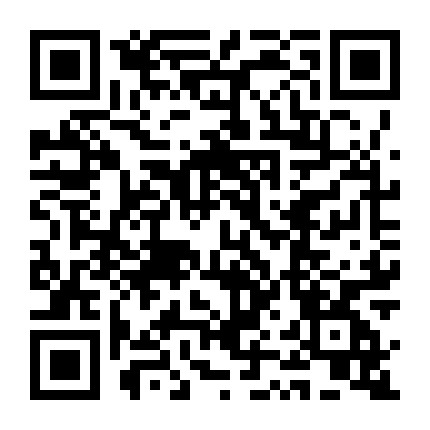

In [25]:
ig = io.BytesIO(response.content)
Image.open(ig)

**然后就可以扫一扫拉，扫描完后我们进行下一步分析**

## 4. 获取好友列表
在登录之后，好友的数据是从哪里来的呢？ 我们逐一看返回的ajax请求发现  
![好友数据](./images/lgin.png)  
数据来自这里，我们看一下请求头:
![好友数据请求](./images/ana_login.png)  
发现有三个参数, 有一个 "skey" 比较特殊，用同样的方法，我们进行 'Ctrl+F' 进行搜索

In [27]:
response = session.get("https://wx2.qq.com/cgi-bin/mmwebwx-bin/webwxgetcontact?r="+ str(time.time()).replace(".", "")[:13] +"&seq=0&skey=@crypt_4a9c92a1_c808f1ac793e52e77e907f76cf7ca086")
response.json()

{'BaseResponse': {'Ret': 1, 'ErrMsg': ''},
 'MemberCount': 0,
 'MemberList': [],
 'Seq': 0}